# Export Gillespie simulation data

```
In `./results/gillespie_sims`:
    - complete.npz
    - random_ER.npz
    - regular.npz
    - scale_free.npz

In `./results/estimates`
    - complete.npz
    - random_ER.npz
    - regular.npz
    - scale_free.npz
```

In [23]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
import sys
sys.path.append('../../src/')
sys.path.append('../../scripts/')
from solve_kolmogorov import *
from simulate_gillespie import *
from estimate_total_rates import *

## Simulation Gillespie runs

In [13]:
# setup
N = 1000
I0 = 50
nsims = 100
time_max = 10.0

In [39]:
test_names = ["complete", "random_ER", "regular", "scale_free"]

In [58]:
# sample part of runs and plot it including average curve and save the data
test_name = test_names[3]

# load simulation results
sim_results = np.load(f'../../results/gillespie_sims/{test_name}.npz', allow_pickle=True)
X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

In [59]:
# TODO: sample some number of X_sims
num_samples = 10
X_sims_sampled = random.sample(X_sims, num_samples)

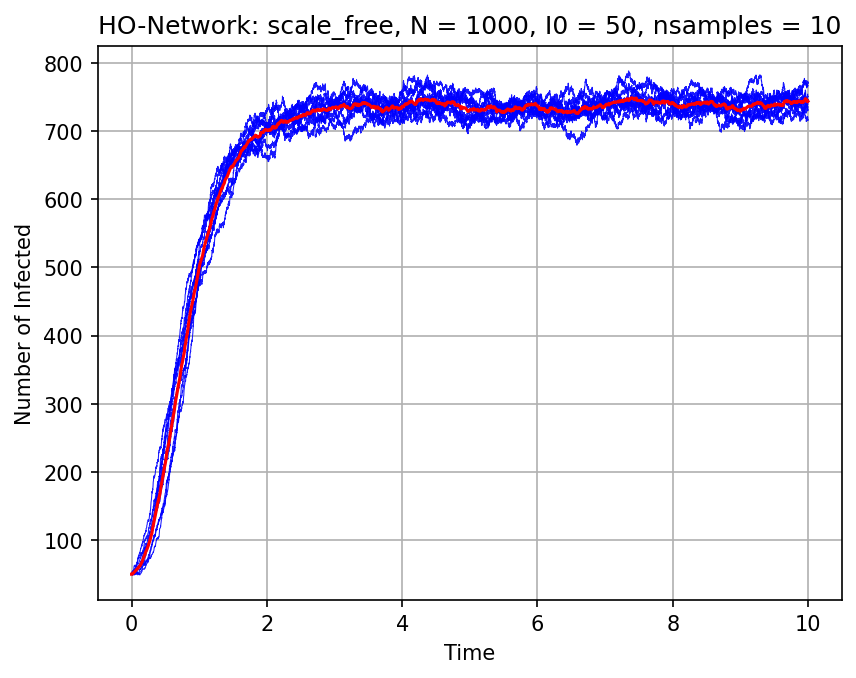

In [66]:
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims_sampled:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims_sampled, time_max, num_samples, delta_t = 0.01)
plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"HO-Network: {test_name}, N = {N}, I0 = {I0}, nsamples = {num_samples}")
plt.show()

In [61]:
output_csv_base_dir = "../../data/gillespie_sims/"
csv_dir = os.path.join(output_csv_base_dir, test_name)
os.makedirs(csv_dir, exist_ok=True)

In [62]:
csv_dir

'../../data/gillespie_sims/scale_free'

### Save as CSV

In [63]:
csv_header = ["t", "waiting_time", "total_infected", "event_type", "total_pw_count", "total_ho_count"]
for i, X_t_s in enumerate(X_sims_sampled):
    data_for_df = []
    for row_idx in range(X_t_s.shape[0]):
        current_row = X_t_s[row_idx, :]
        if row_idx == 3:
            processed_row = ["" if x is None else x for x in current_row]
        else:
            try:
                temp_row = np.array(current_row, dtype=float)
                processed_row = temp_row
            except ValueError:
                 processed_row = [np.nan if x is None else x for x in current_row]
        data_for_df.append(processed_row)

    df_sampled_run = pd.DataFrame(dict(zip(csv_header, data_for_df)))
    df_sampled_run.head()

    sample_number = i + 1
    sampled_run_csv_filename = os.path.join(csv_dir, 
                                            f"continuous_observations_{sample_number}.csv")
    df_sampled_run.to_csv(sampled_run_csv_filename, index=False, header=True)

### Load from CSV

In [64]:
X_sims_loaded_from_csv = []
for i in range(num_samples):
    sample_number = i + 1
    csv_filename = os.path.join(csv_dir, f"continuous_observations_{sample_number}.csv")
    df_loaded_run = pd.read_csv(csv_filename)

    times_loaded = df_loaded_run["t"].to_numpy()
    waiting_times_loaded = df_loaded_run["waiting_time"].to_numpy()
    infected_loaded = df_loaded_run["total_infected"].to_numpy(dtype=int)
    event_types_loaded = df_loaded_run["event_type"].to_numpy()
    pw_counts_loaded = df_loaded_run["total_pw_count"].to_numpy()
    ho_counts_loaded = df_loaded_run["total_ho_count"].to_numpy()

    event_types_processed = np.array([None if pd.isna(x) else x for x in event_types_loaded], dtype=object)

    def nan_to_none_if_object(arr):
        return np.array([None if pd.isna(x) else x for x in arr], dtype=object)

    waiting_times_processed = nan_to_none_if_object(waiting_times_loaded)
    pw_counts_processed = nan_to_none_if_object(pw_counts_loaded)
    ho_counts_processed = nan_to_none_if_object(ho_counts_loaded)

    # stack them into (6, num_events) structure
    X_t_reconstructed = np.array([
        times_loaded,
        waiting_times_processed,
        infected_loaded,
        event_types_processed,
        pw_counts_processed,
        ho_counts_processed
    ], dtype=object) # the outer array is also object type

    X_sims_loaded_from_csv.append(X_t_reconstructed)
    print(f"Loaded and reconstructed run {sample_number}")


Loaded and reconstructed run 1
Loaded and reconstructed run 2
Loaded and reconstructed run 3
Loaded and reconstructed run 4
Loaded and reconstructed run 5
Loaded and reconstructed run 6
Loaded and reconstructed run 7
Loaded and reconstructed run 8
Loaded and reconstructed run 9
Loaded and reconstructed run 10


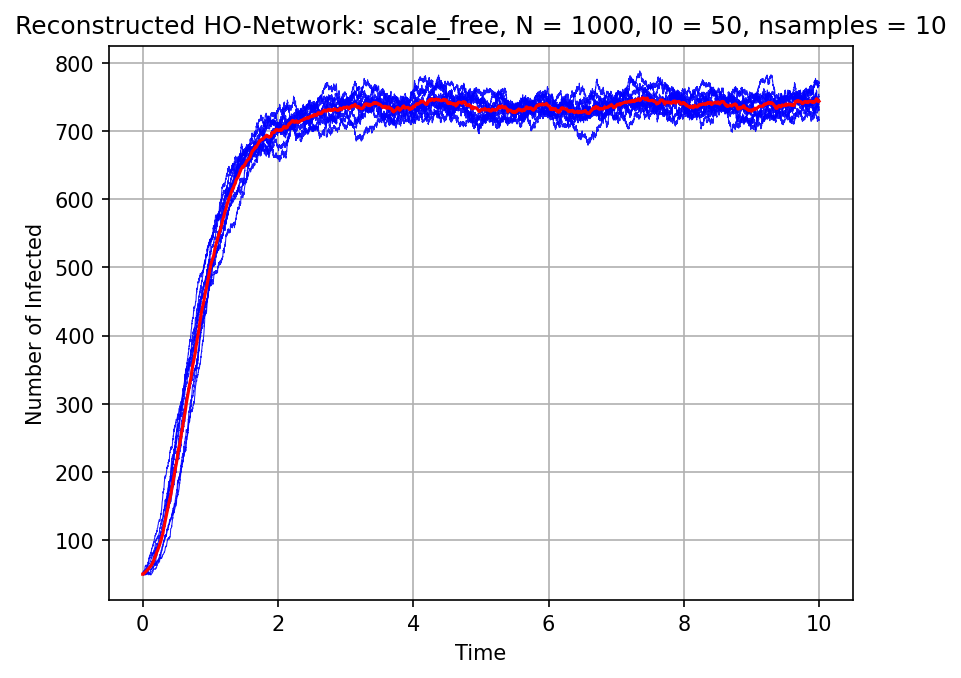

In [67]:
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims_loaded_from_csv:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims_loaded_from_csv, time_max, num_samples, delta_t = 0.01)
plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"Reconstructed HO-Network: {test_name}, N = {N}, I0 = {I0}, nsamples = {num_samples}")
plt.show()